In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
num_steps_train_discriminator = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [ ]:
torch.manual_seed(7777)

def generator_loss(generator_output):
    ############ YOUR CODE HERE ##########
     gen_disc_output = discriminator(generator_output)
     loss = criterion(gen_disc_output, label_real(len(gen_disc_output)))
     return loss
    
    
    ######################################
    
def discriminator_loss(discriminator_output_fake, discriminator_output_true):
    ############ YOUR CODE HERE ##########
    loss_fake = criterion(discriminator_output_fake, label_fake(len(discriminator_output_fake)))
    loss_real = criterion(discriminator_output_true, label_real(len(discriminator_output_true)))
    
    return loss_fake, loss_real
    
    ######################################

# Q. Write training loop

118it [00:58,  2.00it/s]


Epoch 1 of 100
Generator loss: 1.50415192, Discriminator loss: 0.85295564


118it [00:55,  2.12it/s]


Epoch 2 of 100
Generator loss: 2.76945413, Discriminator loss: 0.98100008


118it [00:54,  2.18it/s]


Epoch 3 of 100
Generator loss: 4.07280970, Discriminator loss: 0.66116946


118it [00:54,  2.18it/s]


Epoch 4 of 100
Generator loss: 3.00690846, Discriminator loss: 1.14177907


118it [00:54,  2.17it/s]


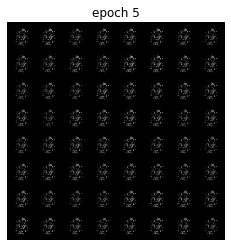

Epoch 5 of 100
Generator loss: 2.58786016, Discriminator loss: 0.92582375


118it [00:53,  2.21it/s]


Epoch 6 of 100
Generator loss: 1.68051732, Discriminator loss: 1.27122298


118it [00:53,  2.22it/s]


Epoch 7 of 100
Generator loss: 1.45487746, Discriminator loss: 1.14017669


118it [00:52,  2.23it/s]


Epoch 8 of 100
Generator loss: 1.33841456, Discriminator loss: 1.18578222


118it [00:55,  2.14it/s]


Epoch 9 of 100
Generator loss: 1.04736038, Discriminator loss: 1.18450005


118it [00:54,  2.15it/s]


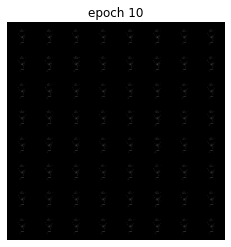

Epoch 10 of 100
Generator loss: 0.94876452, Discriminator loss: 1.19039815


118it [00:55,  2.12it/s]


Epoch 11 of 100
Generator loss: 1.14059889, Discriminator loss: 1.07074089


118it [00:53,  2.19it/s]


Epoch 12 of 100
Generator loss: 1.87389682, Discriminator loss: 0.77546228


118it [00:54,  2.17it/s]


Epoch 13 of 100
Generator loss: 2.65246624, Discriminator loss: 0.83172635


118it [00:54,  2.17it/s]


Epoch 14 of 100
Generator loss: 2.22417354, Discriminator loss: 1.00311134


118it [00:53,  2.19it/s]


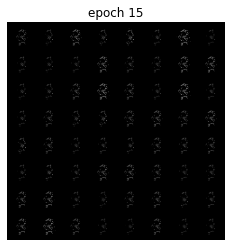

Epoch 15 of 100
Generator loss: 1.57827677, Discriminator loss: 1.02921511


118it [00:54,  2.15it/s]


Epoch 16 of 100
Generator loss: 2.15186931, Discriminator loss: 0.60533345


118it [00:55,  2.14it/s]


Epoch 17 of 100
Generator loss: 2.34409798, Discriminator loss: 0.89206772


118it [00:54,  2.16it/s]


Epoch 18 of 100
Generator loss: 2.56601503, Discriminator loss: 0.67376645


118it [00:54,  2.18it/s]


Epoch 19 of 100
Generator loss: 2.67605593, Discriminator loss: 0.67144563


118it [00:55,  2.14it/s]


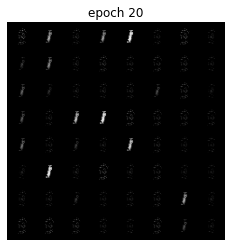

Epoch 20 of 100
Generator loss: 2.47479572, Discriminator loss: 0.75985721


118it [00:54,  2.17it/s]


Epoch 21 of 100
Generator loss: 2.19641702, Discriminator loss: 0.59702533


118it [00:55,  2.14it/s]


Epoch 22 of 100
Generator loss: 2.63270787, Discriminator loss: 0.56519036


118it [00:53,  2.19it/s]


Epoch 23 of 100
Generator loss: 2.57420135, Discriminator loss: 0.48577668


118it [00:54,  2.15it/s]


Epoch 24 of 100
Generator loss: 2.77187818, Discriminator loss: 0.40807014


118it [00:55,  2.14it/s]


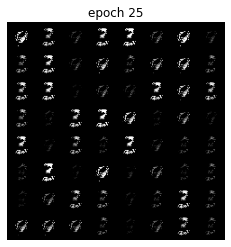

Epoch 25 of 100
Generator loss: 2.87165091, Discriminator loss: 0.51100491


118it [00:54,  2.17it/s]


Epoch 26 of 100
Generator loss: 2.86262033, Discriminator loss: 0.44098954


118it [00:54,  2.15it/s]


Epoch 27 of 100
Generator loss: 3.20709791, Discriminator loss: 0.36957964


118it [00:55,  2.11it/s]


Epoch 28 of 100
Generator loss: 2.79454557, Discriminator loss: 0.65627727


118it [00:55,  2.13it/s]


Epoch 29 of 100
Generator loss: 2.60101173, Discriminator loss: 0.43903778


118it [00:54,  2.18it/s]


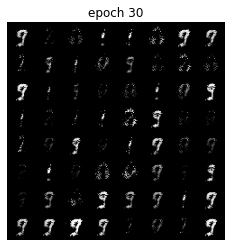

Epoch 30 of 100
Generator loss: 3.24175639, Discriminator loss: 0.36339940


118it [00:55,  2.14it/s]


Epoch 31 of 100
Generator loss: 2.85965421, Discriminator loss: 0.63653916


118it [00:54,  2.16it/s]


Epoch 32 of 100
Generator loss: 2.78805391, Discriminator loss: 0.59077069


118it [00:54,  2.15it/s]


Epoch 33 of 100
Generator loss: 2.92568262, Discriminator loss: 0.49298022


118it [00:54,  2.15it/s]


Epoch 34 of 100
Generator loss: 2.59976949, Discriminator loss: 0.61233685


118it [00:54,  2.15it/s]


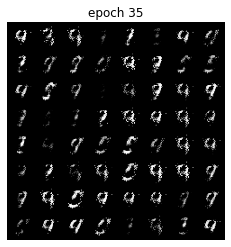

Epoch 35 of 100
Generator loss: 2.62869393, Discriminator loss: 0.58286646


118it [00:54,  2.15it/s]


Epoch 36 of 100
Generator loss: 2.78891539, Discriminator loss: 0.48635358


118it [00:54,  2.17it/s]


Epoch 37 of 100
Generator loss: 3.06447164, Discriminator loss: 0.46595735


118it [00:54,  2.15it/s]


Epoch 38 of 100
Generator loss: 2.81338926, Discriminator loss: 0.56532380


118it [00:55,  2.13it/s]


Epoch 39 of 100
Generator loss: 2.65015673, Discriminator loss: 0.56432267


118it [00:54,  2.15it/s]


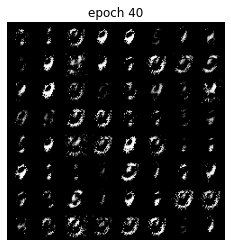

Epoch 40 of 100
Generator loss: 2.64128835, Discriminator loss: 0.58033147


118it [00:54,  2.18it/s]


Epoch 41 of 100
Generator loss: 3.09953557, Discriminator loss: 0.49843960


118it [00:54,  2.15it/s]


Epoch 42 of 100
Generator loss: 2.92314424, Discriminator loss: 0.44465361


118it [00:54,  2.15it/s]


Epoch 43 of 100
Generator loss: 2.89389738, Discriminator loss: 0.51769547


118it [00:54,  2.15it/s]


Epoch 44 of 100
Generator loss: 3.08481003, Discriminator loss: 0.44174985


118it [00:55,  2.13it/s]


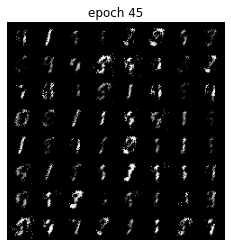

Epoch 45 of 100
Generator loss: 3.01042099, Discriminator loss: 0.48741865


118it [00:56,  2.10it/s]


Epoch 46 of 100
Generator loss: 2.90400079, Discriminator loss: 0.47312489


118it [00:55,  2.11it/s]


Epoch 47 of 100
Generator loss: 2.88549903, Discriminator loss: 0.50467225


118it [00:55,  2.13it/s]


Epoch 48 of 100
Generator loss: 2.89488517, Discriminator loss: 0.53200545


118it [00:54,  2.17it/s]


Epoch 49 of 100
Generator loss: 2.74629071, Discriminator loss: 0.59134242


118it [00:55,  2.11it/s]


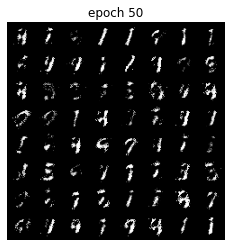

Epoch 50 of 100
Generator loss: 2.59848596, Discriminator loss: 0.58385836


118it [00:54,  2.17it/s]


Epoch 51 of 100
Generator loss: 2.60337785, Discriminator loss: 0.57666972


118it [00:54,  2.16it/s]


Epoch 52 of 100
Generator loss: 2.66361752, Discriminator loss: 0.60922677


118it [00:54,  2.16it/s]


Epoch 53 of 100
Generator loss: 2.97868795, Discriminator loss: 0.51931507


118it [00:55,  2.14it/s]


Epoch 54 of 100
Generator loss: 3.08232035, Discriminator loss: 0.47923584


118it [00:54,  2.15it/s]


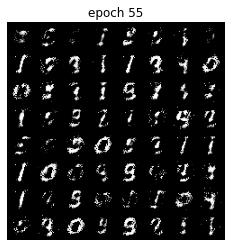

Epoch 55 of 100
Generator loss: 3.00568773, Discriminator loss: 0.51201714


118it [00:56,  2.10it/s]


Epoch 56 of 100
Generator loss: 2.88203844, Discriminator loss: 0.52919671


118it [00:54,  2.17it/s]


Epoch 57 of 100
Generator loss: 2.84310838, Discriminator loss: 0.53496156


118it [00:55,  2.14it/s]


Epoch 58 of 100
Generator loss: 2.88062694, Discriminator loss: 0.53385805


118it [00:55,  2.13it/s]


Epoch 59 of 100
Generator loss: 2.77681929, Discriminator loss: 0.53405652


118it [00:54,  2.16it/s]


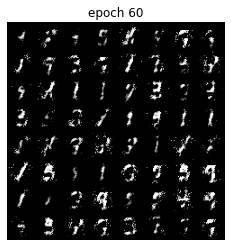

Epoch 60 of 100
Generator loss: 2.92637767, Discriminator loss: 0.57071653


118it [00:54,  2.17it/s]


Epoch 61 of 100
Generator loss: 2.42405486, Discriminator loss: 0.72964266


118it [00:55,  2.14it/s]


Epoch 62 of 100
Generator loss: 2.47140147, Discriminator loss: 0.62271693


118it [00:54,  2.15it/s]


Epoch 63 of 100
Generator loss: 2.74214358, Discriminator loss: 0.57646105


118it [00:53,  2.20it/s]


Epoch 64 of 100
Generator loss: 2.78470784, Discriminator loss: 0.56023472


118it [00:54,  2.16it/s]


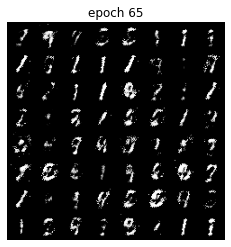

Epoch 65 of 100
Generator loss: 2.79620023, Discriminator loss: 0.52297008


118it [00:54,  2.17it/s]


Epoch 66 of 100
Generator loss: 2.65263396, Discriminator loss: 0.56525870


118it [00:55,  2.14it/s]


Epoch 67 of 100
Generator loss: 2.69344981, Discriminator loss: 0.54404626


118it [00:53,  2.20it/s]


Epoch 68 of 100
Generator loss: 2.54109726, Discriminator loss: 0.60518138


118it [00:54,  2.17it/s]


Epoch 69 of 100
Generator loss: 2.35690194, Discriminator loss: 0.60712879


118it [00:54,  2.17it/s]


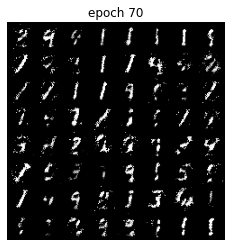

Epoch 70 of 100
Generator loss: 2.56957686, Discriminator loss: 0.60132841


118it [00:54,  2.17it/s]


Epoch 71 of 100
Generator loss: 2.48067602, Discriminator loss: 0.61471853


118it [00:54,  2.18it/s]


Epoch 72 of 100
Generator loss: 2.51737647, Discriminator loss: 0.61410769


118it [00:54,  2.17it/s]


Epoch 73 of 100
Generator loss: 2.52289964, Discriminator loss: 0.59690215


118it [00:54,  2.16it/s]


Epoch 74 of 100
Generator loss: 2.34851477, Discriminator loss: 0.63541834


118it [00:55,  2.11it/s]


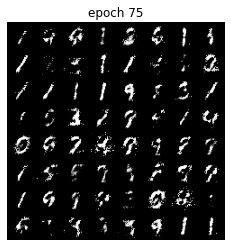

Epoch 75 of 100
Generator loss: 2.34082067, Discriminator loss: 0.67747682


118it [00:55,  2.12it/s]


Epoch 76 of 100
Generator loss: 2.29184542, Discriminator loss: 0.68882424


118it [00:55,  2.11it/s]


Epoch 77 of 100
Generator loss: 2.35019047, Discriminator loss: 0.62666043


118it [00:56,  2.10it/s]


Epoch 78 of 100
Generator loss: 2.24080766, Discriminator loss: 0.63670722


118it [00:55,  2.13it/s]


Epoch 79 of 100
Generator loss: 2.38559618, Discriminator loss: 0.67085980


118it [00:54,  2.15it/s]


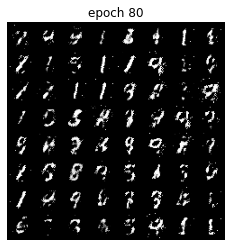

Epoch 80 of 100
Generator loss: 2.25245525, Discriminator loss: 0.70666806


118it [00:55,  2.13it/s]


Epoch 81 of 100
Generator loss: 2.31406958, Discriminator loss: 0.66592161


118it [00:55,  2.13it/s]


Epoch 82 of 100
Generator loss: 2.32826444, Discriminator loss: 0.66799146


118it [00:55,  2.14it/s]


Epoch 83 of 100
Generator loss: 2.32309250, Discriminator loss: 0.67234407


118it [00:55,  2.14it/s]


Epoch 84 of 100
Generator loss: 2.23317481, Discriminator loss: 0.64956762


118it [00:55,  2.13it/s]


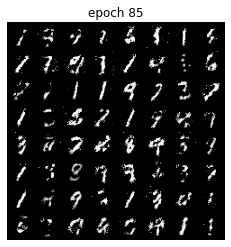

Epoch 85 of 100
Generator loss: 2.16698591, Discriminator loss: 0.68277645


118it [00:55,  2.13it/s]


Epoch 86 of 100
Generator loss: 2.12701381, Discriminator loss: 0.69897446


118it [00:55,  2.14it/s]


Epoch 87 of 100
Generator loss: 2.20463005, Discriminator loss: 0.70110529


118it [00:54,  2.17it/s]


Epoch 88 of 100
Generator loss: 2.25080692, Discriminator loss: 0.68486986


118it [00:55,  2.12it/s]


Epoch 89 of 100
Generator loss: 2.14647679, Discriminator loss: 0.72834314


118it [00:55,  2.13it/s]


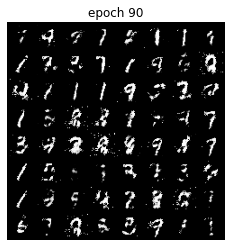

Epoch 90 of 100
Generator loss: 2.12079550, Discriminator loss: 0.72541533


118it [00:55,  2.11it/s]


Epoch 91 of 100
Generator loss: 2.12608249, Discriminator loss: 0.74125365


118it [00:54,  2.17it/s]


Epoch 92 of 100
Generator loss: 2.05488303, Discriminator loss: 0.76060493


118it [00:55,  2.14it/s]


Epoch 93 of 100
Generator loss: 1.98283644, Discriminator loss: 0.77865638


118it [00:54,  2.15it/s]


Epoch 94 of 100
Generator loss: 2.04442892, Discriminator loss: 0.78717714


118it [00:55,  2.12it/s]


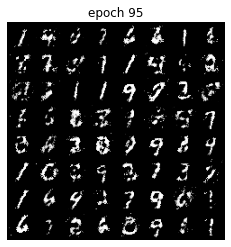

Epoch 95 of 100
Generator loss: 1.95404676, Discriminator loss: 0.77000208


118it [00:54,  2.17it/s]


Epoch 96 of 100
Generator loss: 2.03739283, Discriminator loss: 0.77464428


118it [00:55,  2.14it/s]


Epoch 97 of 100
Generator loss: 2.06887534, Discriminator loss: 0.77938657


118it [00:55,  2.13it/s]


Epoch 98 of 100
Generator loss: 1.94683853, Discriminator loss: 0.78324448


118it [00:55,  2.13it/s]


Epoch 99 of 100
Generator loss: 2.01594690, Discriminator loss: 0.74972107


118it [00:55,  2.14it/s]


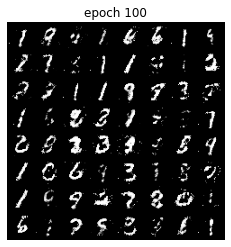

Epoch 100 of 100
Generator loss: 1.96606339, Discriminator loss: 0.77232844


In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        #get the input to device
        data[0].to(device)

        # optimize discriminator
        loss_d_total = 0.0
        if epochs >= 50:
          n = num_steps_train_discriminator + (epochs % 2)
        else:
          n = num_steps_train_discriminator
        for _ in range(n):
          generator_output = generator(create_noise(len(data[0]), nz)).detach() 
          optim_d.zero_grad()
          
          # .detach() to ensure not part of the graph

          #get the preds from discriminator on fake and true data
          gen_disc_output = discriminator(generator_output)
          true_data_output = discriminator(data[0])

          #optimize the loss
          
          disc_loss_fake, disc_loss_real  = discriminator_loss(gen_disc_output, true_data_output) #between fake and true images
          disc_loss_fake.backward()
          disc_loss_real.backward()
          optim_d.step()

          #increase counter
          loss_d_total += (disc_loss_fake+disc_loss_real).detach().cpu().numpy()
    
        # optimize generator
        optim_g.zero_grad()
        generator_output = generator(create_noise(len(data[0]), nz))
        gen_loss = generator_loss(generator_output)
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.detach().cpu().numpy()
        loss_d += loss_d_total / num_steps_train_discriminator
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

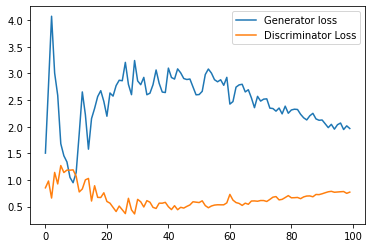

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')